In [3]:
import librosa
import librosa.display
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from matplotlib.pyplot import specgram
import keras
from keras.preprocessing import sequence
from keras.models import Sequential
from keras.layers import Dense, Embedding
from keras.layers import LSTM
from keras.preprocessing.text import Tokenizer
from keras.utils import to_categorical
from keras.layers import Input, Flatten, Dropout, Activation
from keras.layers import Conv1D, MaxPooling1D, AveragePooling1D
from keras.models import Model
from keras.callbacks import ModelCheckpoint
from sklearn.metrics import confusion_matrix

In [4]:
from keras import regularizers

In [5]:
import os

In [6]:
import librosa
from librosa import display

data, sampling_rate = librosa.load('C:\\Users\\satyam\\content\\Actor_01\\03-01-05-02-01-02-01.wav')

C:\Users\satyam\AppData\Local\Temp\ipykernel_5044\3041339362.py:7: WavFileWarning: Chunk (non-data) not understood, skipping it.
  sr,x = scipy.io.wavfile.read('C:\\Users\\satyam\\content\\Actor_01\\03-01-05-02-01-02-01.wav')


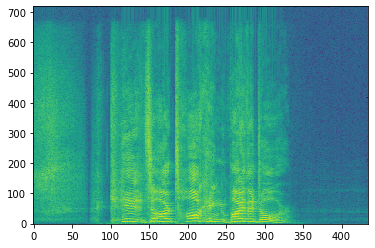

In [9]:
import matplotlib.pyplot as plt
import scipy.io.wavfile
import numpy as np
import sys


sr,x = scipy.io.wavfile.read('C:\\Users\\satyam\\content\\Actor_01\\03-01-05-02-01-02-01.wav')

## Parameters: 10ms step, 30ms window
nstep = int(sr * 0.01)
nwin  = int(sr * 0.03)
nfft = nwin

window = np.hamming(nwin)

## will take windows x[n1:n2].  generate
## and loop over n2 such that all frames
## fit within the waveform
nn = range(nwin, len(x), nstep)

X = np.zeros( (len(nn), nfft//2) )

for i,n in enumerate(nn):
    xseg = x[n-nwin:n]
    z = np.fft.fft(window * xseg, nfft)
    X[i,:] = np.log(np.abs(z[:nfft//2]))

plt.imshow(X.T, interpolation='nearest',
    origin='lower',
    aspect='auto')

plt.show()

In [16]:
import time

path = 'C:\\Users\\satyam\\content\\Actor_01'
lst = []

start_time = time.time()

for subdir, dirs, files in os.walk(path):
  for file in files:
      try:
        #Load librosa array, obtain mfcss, store the file and the mcss information in a new array
        X, sample_rate = librosa.load(os.path.join(subdir,file), res_type='kaiser_fast')
        mfccs = np.mean(librosa.feature.mfcc(y=X, sr=sample_rate, n_mfcc=40).T,axis=0) 
        # The instruction below converts the labels (from 1 to 8) to a series from 0 to 7
        # This is because our predictor needs to start from 0 otherwise it will try to predict also 0.
        file = int(file[7:8]) - 1 
        arr = mfccs, file
        lst.append(arr)
      # If the file is not valid, skip it
      except ValueError:
        continue

print("--- Data loaded. Loading time: %s seconds ---" % (time.time() - start_time))

--- Data loaded. Loading time: 3.3132405281066895 seconds ---


In [17]:
# Creating X and y: zip makes a list of all the first elements, and a list of all the second elements.
X, y = zip(*lst)

In [18]:
import numpy as np
X = np.asarray(X)
y = np.asarray(y)


X.shape, y.shape

((60, 40), (60,))

In [20]:
# Saving joblib files to not load them again with the loop above

import joblib

X_name = 'X.joblib'
y_name = 'y.joblib'
save_dir = 'C:\\Users\\satyam\\content'

savedX = joblib.dump(X, os.path.join(save_dir, X_name))
savedy = joblib.dump(y, os.path.join(save_dir, y_name))


In [22]:
# Loading saved models

X = joblib.load('C:\\Users\\satyam\\content\\X.joblib')
y = joblib.load('C:\\Users\\satyam\\content\\y.joblib')

## Decision Tree Model

In [23]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.30, random_state=11)

In [24]:
from sklearn.tree import DecisionTreeClassifier

In [25]:
dtree = DecisionTreeClassifier()

In [26]:
dtree.fit(X_train, y_train)

DecisionTreeClassifier()

In [27]:
predictions = dtree.predict(X_test)

In [28]:
from sklearn.metrics import classification_report,confusion_matrix
print(classification_report(y_test,predictions))

              precision    recall  f1-score   support

           0       0.20      1.00      0.33         1
           1       0.50      0.67      0.57         3
           2       0.00      0.00      0.00         1
           3       0.50      0.33      0.40         3
           5       0.00      0.00      0.00         4
           6       0.00      0.00      0.00         2
           7       0.00      0.00      0.00         4

    accuracy                           0.22        18
   macro avg       0.17      0.29      0.19        18
weighted avg       0.18      0.22      0.18        18



## Random Forest

In [29]:
from sklearn.ensemble import RandomForestClassifier


In [30]:
rforest = RandomForestClassifier(criterion="gini", max_depth=10, max_features="log2", 
                                 max_leaf_nodes = 100, min_samples_leaf = 3, min_samples_split = 20, 
                                 n_estimators= 22000, random_state= 5)

In [31]:
rforest.fit(X_train, y_train)

RandomForestClassifier(max_depth=10, max_features='log2', max_leaf_nodes=100,
                       min_samples_leaf=3, min_samples_split=20,
                       n_estimators=22000, random_state=5)

In [32]:
predictions = rforest.predict(X_test)

In [33]:
print(classification_report(y_test,predictions))

              precision    recall  f1-score   support

           0       0.00      0.00      0.00         1
           1       0.43      1.00      0.60         3
           2       0.00      0.00      0.00         1
           3       0.00      0.00      0.00         3
           4       0.00      0.00      0.00         0
           5       0.00      0.00      0.00         4
           6       0.00      0.00      0.00         2
           7       0.00      0.00      0.00         4

    accuracy                           0.17        18
   macro avg       0.05      0.12      0.07        18
weighted avg       0.07      0.17      0.10        18



C:\Users\satyam\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\satyam\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\satyam\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\satyam\anaconda3\lib\site-packages\sklearn\metrics\

In [34]:
##Neural Network
x_traincnn = np.expand_dims(X_train, axis=2)
x_testcnn = np.expand_dims(X_test, axis=2)

In [35]:
x_traincnn.shape, x_testcnn.shape

((42, 40, 1), (18, 40, 1))

In [39]:
import tensorflow.keras
from tensorflow.keras import optimizers
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.python.keras import backend as k
from tensorflow.keras.preprocessing import sequence
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Embedding
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.layers import Input, Flatten, Dropout, Activation
from tensorflow.keras.layers import Conv1D, MaxPooling1D
from tensorflow.keras.models import Model
from tensorflow.keras.callbacks import ModelCheckpoint

model = Sequential()

model.add(Conv1D(128, 5,padding='same',
                 input_shape=(40,1)))
model.add(Activation('relu'))
model.add(Dropout(0.1))
model.add(MaxPooling1D(pool_size=(8)))
model.add(Conv1D(128, 5,padding='same',))
model.add(Activation('relu'))
model.add(Dropout(0.1))
model.add(Flatten())
model.add(Dense(8))
model.add(Activation('softmax'))
opt = keras.optimizers.RMSprop(lr=0.00005, rho=0.9, epsilon=None, decay=0.0)

C:\Users\satyam\anaconda3\lib\site-packages\keras\optimizers\optimizer_v2\rmsprop.py:135: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(RMSprop, self).__init__(name, **kwargs)


In [40]:
model.summary()

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d_6 (Conv1D)           (None, 40, 128)           768       
                                                                 
 activation_9 (Activation)   (None, 40, 128)           0         
                                                                 
 dropout_6 (Dropout)         (None, 40, 128)           0         
                                                                 
 max_pooling1d_3 (MaxPooling  (None, 5, 128)           0         
 1D)                                                             
                                                                 
 conv1d_7 (Conv1D)           (None, 5, 128)            82048     
                                                                 
 activation_10 (Activation)  (None, 5, 128)            0         
                                                      

In [41]:
model.compile(loss='sparse_categorical_crossentropy',
              optimizer='adam',
              metrics=['accuracy'])

In [42]:
cnnhistory=model.fit(x_traincnn, y_train, batch_size=16, epochs=1000, validation_data=(x_testcnn, y_test))

Epoch 1/1000
3/3 [==============================] - 2s 260ms/step - loss: 16.5037 - accuracy: 0.1190 - val_loss: 12.2655 - val_accuracy: 0.1667
Epoch 2/1000
3/3 [==============================] - 0s 35ms/step - loss: 18.6282 - accuracy: 0.1429 - val_loss: 12.3080 - val_accuracy: 0.2222
Epoch 3/1000
3/3 [==============================] - 0s 32ms/step - loss: 15.9837 - accuracy: 0.0952 - val_loss: 6.9705 - val_accuracy: 0.1111
Epoch 4/1000
3/3 [==============================] - 0s 33ms/step - loss: 9.4269 - accuracy: 0.0714 - val_loss: 9.6895 - val_accuracy: 0.0556
Epoch 5/1000
3/3 [==============================] - 0s 40ms/step - loss: 12.9463 - accuracy: 0.0952 - val_loss: 5.5849 - val_accuracy: 0.2222
Epoch 6/1000
3/3 [==============================] - 0s 32ms/step - loss: 8.9868 - accuracy: 0.0952 - val_loss: 4.4818 - val_accuracy: 0.2222
Epoch 7/1000
3/3 [==============================] - 0s 38ms/step - loss: 8.0878 - accuracy: 0.1667 - val_loss: 5.3699 - val_accuracy: 0.1111
Epoch 

Epoch 59/1000
3/3 [==============================] - 0s 41ms/step - loss: 1.2432 - accuracy: 0.5000 - val_loss: 1.5619 - val_accuracy: 0.5556
Epoch 60/1000
3/3 [==============================] - 0s 39ms/step - loss: 1.3403 - accuracy: 0.5476 - val_loss: 1.4210 - val_accuracy: 0.5000
Epoch 61/1000
3/3 [==============================] - 0s 39ms/step - loss: 1.4040 - accuracy: 0.4762 - val_loss: 1.4245 - val_accuracy: 0.5000
Epoch 62/1000
3/3 [==============================] - 0s 39ms/step - loss: 1.2391 - accuracy: 0.4762 - val_loss: 1.3887 - val_accuracy: 0.5000
Epoch 63/1000
3/3 [==============================] - 0s 42ms/step - loss: 1.4282 - accuracy: 0.4524 - val_loss: 1.4338 - val_accuracy: 0.5556
Epoch 64/1000
3/3 [==============================] - 0s 36ms/step - loss: 1.1273 - accuracy: 0.5952 - val_loss: 1.4807 - val_accuracy: 0.6111
Epoch 65/1000
3/3 [==============================] - 0s 40ms/step - loss: 1.1472 - accuracy: 0.6190 - val_loss: 1.5174 - val_accuracy: 0.5556
Epoch 

3/3 [==============================] - 0s 36ms/step - loss: 0.2561 - accuracy: 0.9524 - val_loss: 1.5097 - val_accuracy: 0.7222
Epoch 174/1000
3/3 [==============================] - 0s 38ms/step - loss: 0.3082 - accuracy: 0.8810 - val_loss: 1.3693 - val_accuracy: 0.6667
Epoch 175/1000
3/3 [==============================] - 0s 41ms/step - loss: 0.2682 - accuracy: 0.9524 - val_loss: 1.2625 - val_accuracy: 0.7222
Epoch 176/1000
3/3 [==============================] - 0s 37ms/step - loss: 0.1271 - accuracy: 1.0000 - val_loss: 1.2675 - val_accuracy: 0.6667
Epoch 177/1000
3/3 [==============================] - 0s 39ms/step - loss: 0.1295 - accuracy: 0.9762 - val_loss: 1.3390 - val_accuracy: 0.6111
Epoch 178/1000
3/3 [==============================] - 0s 39ms/step - loss: 0.1341 - accuracy: 0.9762 - val_loss: 1.3120 - val_accuracy: 0.6667
Epoch 179/1000
3/3 [==============================] - 0s 41ms/step - loss: 0.1456 - accuracy: 0.9762 - val_loss: 1.2843 - val_accuracy: 0.7222
Epoch 180/1000

3/3 [==============================] - 0s 43ms/step - loss: 0.0449 - accuracy: 1.0000 - val_loss: 1.2896 - val_accuracy: 0.6111
Epoch 288/1000
3/3 [==============================] - 0s 35ms/step - loss: 0.0420 - accuracy: 1.0000 - val_loss: 1.3567 - val_accuracy: 0.6111
Epoch 289/1000
3/3 [==============================] - 0s 37ms/step - loss: 0.0541 - accuracy: 1.0000 - val_loss: 1.3374 - val_accuracy: 0.6111
Epoch 290/1000
3/3 [==============================] - 0s 34ms/step - loss: 0.0604 - accuracy: 1.0000 - val_loss: 1.3014 - val_accuracy: 0.7222
Epoch 291/1000
3/3 [==============================] - 0s 36ms/step - loss: 0.0420 - accuracy: 1.0000 - val_loss: 1.4923 - val_accuracy: 0.6667
Epoch 292/1000
3/3 [==============================] - 0s 35ms/step - loss: 0.1099 - accuracy: 0.9524 - val_loss: 1.5842 - val_accuracy: 0.6111
Epoch 293/1000
3/3 [==============================] - 0s 36ms/step - loss: 0.0902 - accuracy: 0.9762 - val_loss: 1.4981 - val_accuracy: 0.5000
Epoch 294/1000

3/3 [==============================] - 0s 33ms/step - loss: 0.0200 - accuracy: 1.0000 - val_loss: 1.5278 - val_accuracy: 0.6667
Epoch 402/1000
3/3 [==============================] - 0s 41ms/step - loss: 0.0167 - accuracy: 1.0000 - val_loss: 1.6155 - val_accuracy: 0.6667
Epoch 403/1000
3/3 [==============================] - 0s 35ms/step - loss: 0.0260 - accuracy: 1.0000 - val_loss: 1.7723 - val_accuracy: 0.6667
Epoch 404/1000
3/3 [==============================] - 0s 38ms/step - loss: 0.0458 - accuracy: 0.9762 - val_loss: 1.7572 - val_accuracy: 0.6667
Epoch 405/1000
3/3 [==============================] - 0s 43ms/step - loss: 0.0250 - accuracy: 1.0000 - val_loss: 1.7058 - val_accuracy: 0.6667
Epoch 406/1000
3/3 [==============================] - 0s 46ms/step - loss: 0.0205 - accuracy: 1.0000 - val_loss: 1.6660 - val_accuracy: 0.6667
Epoch 407/1000
3/3 [==============================] - 0s 42ms/step - loss: 0.0125 - accuracy: 1.0000 - val_loss: 1.6352 - val_accuracy: 0.6667
Epoch 408/1000

3/3 [==============================] - 0s 33ms/step - loss: 0.0081 - accuracy: 1.0000 - val_loss: 1.8280 - val_accuracy: 0.6111
Epoch 516/1000
3/3 [==============================] - 0s 34ms/step - loss: 0.0104 - accuracy: 1.0000 - val_loss: 1.7279 - val_accuracy: 0.6667
Epoch 517/1000
3/3 [==============================] - 0s 33ms/step - loss: 0.0132 - accuracy: 1.0000 - val_loss: 1.5796 - val_accuracy: 0.6667
Epoch 518/1000
3/3 [==============================] - 0s 34ms/step - loss: 0.0056 - accuracy: 1.0000 - val_loss: 1.5070 - val_accuracy: 0.6667
Epoch 519/1000
3/3 [==============================] - 0s 35ms/step - loss: 0.0051 - accuracy: 1.0000 - val_loss: 1.4715 - val_accuracy: 0.6667
Epoch 520/1000
3/3 [==============================] - 0s 41ms/step - loss: 0.0105 - accuracy: 1.0000 - val_loss: 1.5432 - val_accuracy: 0.6667
Epoch 521/1000
3/3 [==============================] - 0s 34ms/step - loss: 0.0030 - accuracy: 1.0000 - val_loss: 1.6303 - val_accuracy: 0.6667
Epoch 522/1000

3/3 [==============================] - 0s 40ms/step - loss: 0.0064 - accuracy: 1.0000 - val_loss: 2.0108 - val_accuracy: 0.6667
Epoch 630/1000
3/3 [==============================] - 0s 42ms/step - loss: 0.0045 - accuracy: 1.0000 - val_loss: 2.1209 - val_accuracy: 0.6667
Epoch 631/1000
3/3 [==============================] - 0s 39ms/step - loss: 0.0079 - accuracy: 1.0000 - val_loss: 2.0473 - val_accuracy: 0.6667
Epoch 632/1000
3/3 [==============================] - 0s 41ms/step - loss: 0.0049 - accuracy: 1.0000 - val_loss: 1.9146 - val_accuracy: 0.6667
Epoch 633/1000
3/3 [==============================] - 0s 30ms/step - loss: 0.0059 - accuracy: 1.0000 - val_loss: 1.7925 - val_accuracy: 0.6667
Epoch 634/1000
3/3 [==============================] - 0s 21ms/step - loss: 0.0033 - accuracy: 1.0000 - val_loss: 1.7127 - val_accuracy: 0.6667
Epoch 635/1000
3/3 [==============================] - 0s 21ms/step - loss: 0.0019 - accuracy: 1.0000 - val_loss: 1.6898 - val_accuracy: 0.6667
Epoch 636/1000

3/3 [==============================] - 0s 19ms/step - loss: 0.0031 - accuracy: 1.0000 - val_loss: 1.8502 - val_accuracy: 0.6667
Epoch 744/1000
3/3 [==============================] - 0s 19ms/step - loss: 0.0088 - accuracy: 1.0000 - val_loss: 1.9240 - val_accuracy: 0.6667
Epoch 745/1000
3/3 [==============================] - 0s 20ms/step - loss: 0.0033 - accuracy: 1.0000 - val_loss: 1.9731 - val_accuracy: 0.6111
Epoch 746/1000
3/3 [==============================] - 0s 21ms/step - loss: 0.0053 - accuracy: 1.0000 - val_loss: 1.9592 - val_accuracy: 0.6111
Epoch 747/1000
3/3 [==============================] - 0s 19ms/step - loss: 0.0011 - accuracy: 1.0000 - val_loss: 1.9251 - val_accuracy: 0.6111
Epoch 748/1000
3/3 [==============================] - 0s 17ms/step - loss: 0.0018 - accuracy: 1.0000 - val_loss: 1.9029 - val_accuracy: 0.6667
Epoch 749/1000
3/3 [==============================] - 0s 18ms/step - loss: 0.0027 - accuracy: 1.0000 - val_loss: 1.8867 - val_accuracy: 0.6667
Epoch 750/1000

3/3 [==============================] - 0s 25ms/step - loss: 0.0017 - accuracy: 1.0000 - val_loss: 1.9426 - val_accuracy: 0.6667
Epoch 858/1000
3/3 [==============================] - 0s 29ms/step - loss: 0.0020 - accuracy: 1.0000 - val_loss: 1.8936 - val_accuracy: 0.6667
Epoch 859/1000
3/3 [==============================] - 0s 27ms/step - loss: 0.0015 - accuracy: 1.0000 - val_loss: 1.8706 - val_accuracy: 0.6667
Epoch 860/1000
3/3 [==============================] - 0s 31ms/step - loss: 0.0094 - accuracy: 1.0000 - val_loss: 1.8593 - val_accuracy: 0.6667
Epoch 861/1000
3/3 [==============================] - 0s 37ms/step - loss: 0.0043 - accuracy: 1.0000 - val_loss: 1.9380 - val_accuracy: 0.6667
Epoch 862/1000
3/3 [==============================] - 0s 24ms/step - loss: 0.0014 - accuracy: 1.0000 - val_loss: 2.0207 - val_accuracy: 0.7222
Epoch 863/1000
3/3 [==============================] - 0s 24ms/step - loss: 0.0060 - accuracy: 1.0000 - val_loss: 2.1127 - val_accuracy: 0.7222
Epoch 864/1000

Epoch 971/1000
3/3 [==============================] - 0s 21ms/step - loss: 0.0015 - accuracy: 1.0000 - val_loss: 2.1414 - val_accuracy: 0.6111
Epoch 972/1000
3/3 [==============================] - 0s 22ms/step - loss: 0.0025 - accuracy: 1.0000 - val_loss: 2.1095 - val_accuracy: 0.6111
Epoch 973/1000
3/3 [==============================] - 0s 22ms/step - loss: 0.0018 - accuracy: 1.0000 - val_loss: 2.0723 - val_accuracy: 0.6667
Epoch 974/1000
3/3 [==============================] - 0s 27ms/step - loss: 0.0039 - accuracy: 1.0000 - val_loss: 2.0214 - val_accuracy: 0.6667
Epoch 975/1000
3/3 [==============================] - 0s 24ms/step - loss: 0.0016 - accuracy: 1.0000 - val_loss: 1.9546 - val_accuracy: 0.6667
Epoch 976/1000
3/3 [==============================] - 0s 24ms/step - loss: 5.8957e-04 - accuracy: 1.0000 - val_loss: 1.9270 - val_accuracy: 0.6667
Epoch 977/1000
3/3 [==============================] - 0s 26ms/step - loss: 7.5343e-04 - accuracy: 1.0000 - val_loss: 1.9203 - val_accuracy

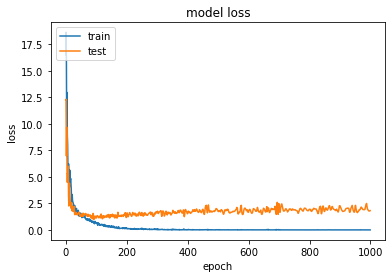

In [43]:
# Loss 
plt.plot(cnnhistory.history['loss'])
plt.plot(cnnhistory.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

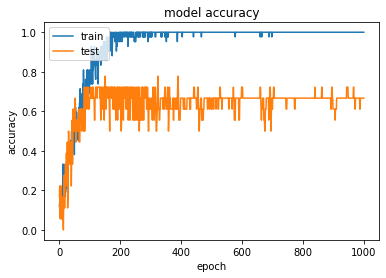

In [44]:
## This is for Accuracy
plt.plot(cnnhistory.history['accuracy'])
plt.plot(cnnhistory.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

In [46]:
predictions = (model.predict(x_testcnn)>0.5)


1/1 [==============================] - 0s 120ms/step


In [47]:
predictions

array([[False, False, False, False, False,  True, False, False],
       [False, False, False,  True, False, False, False, False],
       [False, False, False, False, False,  True, False, False],
       [False, False, False, False, False,  True, False, False],
       [False, False,  True, False, False, False, False, False],
       [False, False, False, False, False,  True, False, False],
       [False,  True, False, False, False, False, False, False],
       [False, False, False,  True, False, False, False, False],
       [ True, False, False, False, False, False, False, False],
       [False, False, False,  True, False, False, False, False],
       [False, False, False,  True, False, False, False, False],
       [ True, False, False, False, False, False, False, False],
       [False, False, False, False, False, False, False,  True],
       [False, False, False,  True, False, False, False, False],
       [False, False, False, False,  True, False, False, False],
       [False,  True, Fal

In [48]:
y_test

array([5, 3, 5, 5, 2, 5, 1, 6, 0, 6, 7, 1, 7, 3, 7, 1, 7, 3])

In [49]:
new_Ytest = y_test.astype(int)

In [50]:
new_Ytest

array([5, 3, 5, 5, 2, 5, 1, 6, 0, 6, 7, 1, 7, 3, 7, 1, 7, 3])

In [57]:
model_name = 'Emotion_Voice_Detection_Model.h5'
save_dir = 'C:\\Users\\satyam\\content\\'
# Save model and weights
if not os.path.isdir(save_dir):
    os.makedirs(save_dir)
model_path = os.path.join(save_dir, model_name)
model.save(model_path)
print('Saved trained model at %s ' % model_path)

Saved trained model at C:\Users\satyam\content\Emotion_Voice_Detection_Model.h5 


In [58]:
from tensorflow import keras

from tensorflow.keras.models import load_model

from tensorflow.keras.utils import CustomObjectScope

from tensorflow.keras.initializers import glorot_uniform

with CustomObjectScope({'GlorotUniform': glorot_uniform()}):

    loaded_model = load_model('C:\\Users\\satyam\\content\\Emotion_Voice_Detection_Model.h5')
    loaded_model.summary()

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d_6 (Conv1D)           (None, 40, 128)           768       
                                                                 
 activation_9 (Activation)   (None, 40, 128)           0         
                                                                 
 dropout_6 (Dropout)         (None, 40, 128)           0         
                                                                 
 max_pooling1d_3 (MaxPooling  (None, 5, 128)           0         
 1D)                                                             
                                                                 
 conv1d_7 (Conv1D)           (None, 5, 128)            82048     
                                                                 
 activation_10 (Activation)  (None, 5, 128)            0         
                                                      

In [59]:
loss, acc = loaded_model.evaluate(x_testcnn, y_test)
print("Restored model, accuracy: {:5.2f}%".format(100*acc))

1/1 [==============================] - 0s 176ms/step - loss: 1.8104 - accuracy: 0.6667
Restored model, accuracy: 66.67%
